# Automatic Differentiation

This is companion to the medium article on automatic differentiation

## Define the computational graph

In [1]:
import numpy as np

class Graph():
    """ Computational graph class. 
    Initilizes a global variable _g that describes the graph.
    Each graph consists of a set of
        1. operators
        2. variables
        3. constants
        4. placeholders
    """
    def __init__(self):
        self.operators = set()
        self.constants = set()
        self.variables = set()
        self.placeholders = set()
        global _g
        _g = self
        
    def reset_counts(self, root):
        if hasattr(root, 'count'):
            root.count = 0
        else:
            for child in root.__subclasses__():
                self.reset_counts(child)

    def reset_session(self):
        try:
            del _g
        except:
            pass
        self.reset_counts(Node)
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.reset_session()

## Define the graph nodes. 

The operator node is virtual, it is never called. Only subclasses of it containing actual operations should ever be called.

### Make a basic Node class to inherit from

This won't do anything other than allow us to check if in object is a Graph node or not

In [2]:
class Node:
    def __init__(self):
        pass

### Define Variables, Constants, Placeholders, and Operators

#### Placeholders

In [3]:
class Placeholder(Node):
    """An placeholder node in the computational graph. This holds
    a node, and awaits further input at computation time.
    Args: 
        name: defaults to "Plc/"+count
        dtype: the type that the node holds, float, int, etc.
    """
    count = 0
    def __init__(self, name, dtype=float):
        _g.placeholders.add(self)
        self.value = None
        self.gradient = None
        self.name = f"Plc/{Placeholder.count}" if name is None else name
        Placeholder.count += 1
        
    def __repr__(self):
        return f"Placeholder: name:{self.name}, value:{self.value}"

#### Constants

In [4]:
class Constant(Node):
    """An constant node in the computational graph.
    Args: 
        name: defaults to "const/"+count
        value: a property protected value that prevents user 
               from reassigning value
    """
    count = 0
    def __init__(self, value, name=None):
        _g.constants.add(self)
        self._value = value
        self.gradient = None
        self.name = f"Const/{Constant.count}" if name is None else name
        Constant.count += 1
        
    def __repr__(self):
        return f"Constant: name:{self.name}, value:{self.value}"
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self):
        raise ValueError("Cannot reassign constant")

#### Variables

In [5]:
class Variable(Node):
    """An variable node in the computational graph. Variables are
    automatically tracked during graph computation.
    Args: 
        name: defaults to "var/"+count
        value: a mutable value
    """
    count = 0
    def __init__(self, value, name=None):
        _g.variables.add(self)
        self.value = value
        self.gradient = None
        self.name = f"Var/{Variable.count}" if name is None else name
        Variable.count += 1
        
    def __repr__(self):
        return f"Variable: name:{self.name}, value:{self.value}"

#### Define Operators

This way, we can provide addition and multiplication as dunder functions, and overload the python operators '+' and '*'.

In [6]:
class Operator(Node):
    """An operator node in the computational graph.
    Args: 
        name: defaults to "operator name/"+count
    """
    def __init__(self, name='Operator'):
        _g.operators.add(self)
        self.value = None
        self.inputs = []
        self.gradient = None
        self.name = name
    
    def __repr__(self):
        return f"Operator: name:{self.name}"

### Create some actual operators that do things

In [7]:
class add(Operator):
    count = 0
    """Binary addition operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'add/{add.count}' if name is None else name
        add.count += 1
        
    def forward(self, a, b):
        return a+b
    
    def backward(self, a, b, dout):
        return dout, dout

class multiply(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'mul/{multiply.count}' if name is None else name
        multiply.count += 1
        
    def forward(self, a, b):
        return a*b
    
    def backward(self, a, b, dout):
        return dout*b, dout*a
    
class divide(Operator):
    count = 0
    """Binary division operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'div/{divide.count}' if name is None else name
        divide.count += 1
   
    def forward(self, a, b):
        return a/b
    
    def backward(self, a, b, dout):
        return dout/b, dout*a/np.power(b, 2)
    
    
class power(Operator):
    count = 0
    """Binary exponentiation operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'pow/{power.count}' if name is None else name
        power.count += 1
   
    def forward(self, a, b):
        return np.power(a, b)
    
    def backward(self, a, b, dout):
        return dout*b*np.power(a, (b-1)), dout*np.log(a)*np.power(a, b)
    
class matmul(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'matmul/{matmul.count}' if name is None else name
        matmul.count += 1
        
    def forward(self, a, b):
        return a@b
    
    def backward(self, a, b, dout):
        return dout@b.T, a.T@dout

## For convenience, overload all of these

In [8]:
def node_wrapper(func, self, other):
    if isinstance(other, Node):
        return func(self, other)
    if isinstance(other, float) or isinstance(other, int):
        return func(self, Constant(other))
    raise TypeError("Incompatible types.")

Node.__add__ = lambda self, other: node_wrapper(add, self, other)
Node.__mul__ = lambda self, other: node_wrapper(multiply, self, other)
Node.__div__ = lambda self, other: node_wrapper(divide, self, other)
Node.__neg__ = lambda self: node_wrapper(multiply, self, Constant(-1))
Node.__pow__ = lambda self, other: node_wrapper(power, self, other)
Node.__matmul__ = lambda self, other: node_wrapper(matmul, self, other)

## Test it out!

In [9]:
with Graph() as g:
    x = Variable(1.3)
    y = Variable(0.9)
    z = x*y+5

In [10]:
print(g.constants)
print(g.variables)
print(g.operators)

{Constant: name:Const/0, value:5}
{Variable: name:Var/0, value:1.3, Variable: name:Var/1, value:0.9}
{Operator: name:mul/0, Operator: name:add/0}


# Autograd

In [11]:
def topological_sort(head_node=None, graph=_g):
    """Performs topological sort of all nodes prior to and 
    including the head_node. 
    Args:
        graph: the computational graph. This is the global value by default
        head_node: last node in the forward pass. The "result" of the graph.
    Returns:
        a sorted array of graph nodes.
    """
    vis = set()
    ordering = []
    
    def _dfs(node):
        if node not in vis:
            vis.add(node)
            if isinstance(node, Operator):
                for input_node in node.inputs:
                    _dfs(input_node)
            ordering.append(node)
            
    if head_node is None:
        for node in graph.operators:
            _dfs(node)
    else:
        _dfs(head_node)
        
    return ordering

In [12]:
def forward_pass(order, feed_dict={}):
    """ Performs the forward pass, returning the output of the graph.
    Args:
        order: a topologically sorted array of nodes
        feed_dict: a dictionary values for placeholders.
    Returns:
        1. the final result of the forward pass.
        2. directly edits the graph to fill in its current values.
    """
    for node in order:
        
        if isinstance(node, Placeholder):
            node.value = feed_dict[node.name]
                    
        elif isinstance(node, Operator):
            node.value = node.forward(*[prev_node.value for prev_node in node.inputs])

    return order[-1].value

In [13]:
def backward_pass(order, target_node=None):
    """ Perform the backward pass to retrieve gradients.
    Args:
        order: a topologically sorted array of graph nodes.
               by default, this assigns the graident of the final node to 1
    Returns:
        gradients of nodes as listed in same order as input argument
    """
    vis = set()
    order[-1].gradient = 1
    for node in reversed(order):
        if isinstance(node, Operator):
            inputs = node.inputs
            grads = node.backward(*[x.value for x in inputs], dout=node.gradient)
            for inp, grad in zip(inputs, grads):
                if inp not in vis:
                    inp.gradient = grad
                else:
                    inp.gradient += grad
                vis.add(inp)
    return [node.gradient for node in order]

In [14]:
val1, val2, val3 = 0.9, 0.4, 1.3

with Graph() as g:
    x = Variable(val1, name='x')
    y = Variable(val2, name='y')
    c = Constant(val3, name='c')
    z = (x*y+c)*c + x

    order = topological_sort(z)
    res = forward_pass(order)
    grads = backward_pass(order)

    print("Node ordering:")
    for node in order:
        print(node)

    print('-'*10)
    print(f"Forward pass expected: {(val1*val2+val3)*val3+val1}")
    print(f"Forward pass computed: {res}")

Node ordering:
Variable: name:x, value:0.9
Variable: name:y, value:0.4
Operator: name:mul/0
Constant: name:c, value:1.3
Operator: name:add/0
Operator: name:mul/1
Operator: name:add/1
----------
Forward pass expected: 3.0580000000000003
Forward pass computed: 3.0580000000000003


In [15]:
dzdx_node = [a for a in order if a.name=='x'][0]
dzdy_node = [a for a in order if a.name=='y'][0]
dzdc_node = [a for a in order if a.name=='c'][0]

print(f"dz/dx expected = {val3*val2+1}")
print(f"dz/dx computed = {dzdx_node.gradient}")

print(f"dz/dy expected = {val1*val3}")
print(f"dz/dy computed = {dzdy_node.gradient}")

print(f"dz/dc expected = {val1*val2+2*val3}")
print(f"dz/dc computed = {dzdc_node.gradient}")

dz/dx expected = 1.52
dz/dx computed = 1.52
dz/dy expected = 1.1700000000000002
dz/dy computed = 1.1700000000000002
dz/dc expected = 2.96
dz/dc computed = 2.96


In [16]:
from graphviz import Digraph

def make_graph(graph):
    """Allows us to visualize the computation graph directly in a Jupyter notebook.
    must have graphviz module installed. Takes as input the topological sorted ordering
    after calling the Session class"""
    f = Digraph()
    f.attr(rankdir='LR', size='10, 8')
    f.attr('node', shape='circle')
    for node in graph:
        shape = 'box' if isinstance(node, Placeholder) else 'circle'
        f.node(node.name, label=node.name.split('/')[0], shape=shape)
    for node in graph:
        if isinstance(node, Operator):
            for e in node.inputs:
                f.edge(e.name, node.name, label=e.name)
    return f

### Here's the slightly more complicated graph towards the end of the article

In [17]:
order

[Variable: name:x, value:0.9,
 Variable: name:y, value:0.4,
 Operator: name:mul/0,
 Constant: name:c, value:1.3,
 Operator: name:add/0,
 Operator: name:mul/1,
 Operator: name:add/1]

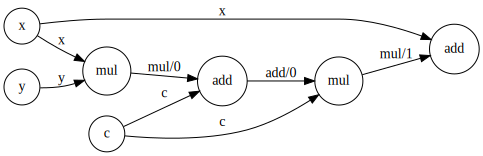

In [18]:
my_graph = make_graph(order)
my_graph

### Here's the simple graph at the start of the article

In [19]:
with Graph() as g:
    x = Variable(1., name='x')
    y = Variable(2., name='y')
    z = Variable(3., name='z')
    loss = x*y+z

In [20]:
ordering = topological_sort(loss)

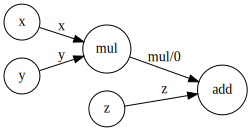

In [21]:
my_graph = make_graph(ordering)
my_graph